# FDTD

These are my notes on FDTD. My plan is to build a one-dimension simulation including non-linear effects of second and third order. I'll do this in baby steps, so this also works as a gentle introduction to FDTD.

Maxwell's equations in source free areas:
\begin{align}
\nabla \times \mathbf{E} & = -\frac{\partial\mathbf{B}}{\partial t} \\
\nabla \times \mathbf{H} & = \frac{\partial\mathbf{D}}{\partial t} \\
\nabla \cdot \mathbf{D} & = 0 \\
\nabla \cdot \mathbf{B} & = 0
\end{align}

Python headers go here:

In [7]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import time

from scipy.constants import c,pi,mu_0,epsilon_0

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## PART 1: Free space simulation

We'll consider a medium that varies just in one dimension. Let's set rectangular axes so that the medium is uniform in the x and y directions, and can vary only in the z direction. We'll also assume that the EM fields are uniform in the x-y plane, so we have:

$$
\frac{\partial}{\partial x} = 0, \, \frac{\partial}{\partial y} = 0,
$$
in Maxwell's equations. This leads to a pair of decoupled transversal modes which are mathematically indistiguishable (in an isotropic medium), so we'll just stick to one, namely, $E_x = H_y = 0$. In this case Maxwell's equations in free space reduce to:

\begin{align}
\frac{\partial E_y}{\partial z} = \mu_0 \frac{\partial H_x}{\partial t} \label{MaxEq_1D_1} \\
\frac{\partial H_x}{\partial z} = \epsilon_0 \frac{\partial E_y}{\partial t} \\
\frac{\partial E_z}{\partial t} = \frac{\partial H_z}{\partial t} = 0.
\end{align}

The last equation shows that if the fields start at zero, then the longitudinal component stays at zero, i.e. $E_z = H_z = 0$.

### The Field Source

For this first case let's just consider a simple monochromatic source:
$$
E(t) = \sin(\omega t)
$$

In [2]:
freq = 3e9
w = 2*pi*freq

### The grid

It is time to approximate our domain of simulation with a discrete grid. Suppose we wish to divide the total length $L_T$ in cells of size $\Delta_z$. The total number of cells is $N_T = L_T/\Delta_z$, and it should be an integer. On the other hand $\Delta_z$ should be small compared to the minimum wavelength used in the simulation. If we decide to use $N_\lambda$ cells per wavelength, then:
$$
\Delta_x < \frac{\lambda}{N_\lambda} \\
$$

In [3]:
L_T = 2
N_l = 100

wavelength = c/freq
dz1 = wavelength/N_l
N_T = round(L_T/dz1)+1
dz = L_T/N_T

print("Wavelength = ", wavelength)
print("N_T = ", N_T)
print("d_z = ", dz)

Wavelength =  0.09993081933333334
N_T =  2002
d_z =  0.000999000999000999


In this notebook we will locate the magnetic field in the center of each cell, while the electric field will be at the edges of each cell. In this case, boundary conditions only need to be applied to the electric field.

The magnetic field can then be represented with a vector of length $N_T$, at each instant of time. For the electric field we'll need a vector with $N_T+1$ elements, the first and last of which are located at the boundaries of the simulation region.

In [4]:
#ey = np.zeros(N_T+1)
#hx = np.zeros(N_T)

### The Time Step

We cannot step the FDTD too fast, i.e., $\Delta t$ cannot be too large. This is, of course, because EM waves propagate at a finite speed. In general, we can write:
$$
\Delta t = S \frac{\Delta z}{c},
$$
where $S$ is the Courant factor. For our purposes choosing $S=0.5$ is sufficient.

In [5]:
S = 0.5
dt = S*dz/c
print(dt)

1.666154321669091e-12


###  The Update Equations

We are going to represent the fields as vectors, so we can index them with two integers, the first for the spatial coordinate and the second for the time coordinate:
$$
E(z,t) \rightarrow e(k,n) \\
H(z,t) \rightarrow h(k,n),
$$
where we've used lowercase symbols to indicate the discrete vector approximation. The main point to note here is that the electric and magnetic fields are interleaved in space and time, so $k$ and $n$ represent different locations and times for both fields. Specifically:
$$
e(k,n) = E(k\Delta z, n\Delta t) \\
h(k,n) = H(k\Delta z + \Delta z/2, n\Delta t + \Delta t/2). \\
$$
So, we have decide to offset the magnetic field by half-a-cell in both, space and time.

Next, let's apply the finite difference apporximation to Maxwell's equations. Faraday's law allows to update the magnetic field from the electric field as follows:
$$
\begin{align}
\frac{\partial E_y}{\partial z} &= \mu_0 \frac{\partial H_x}{\partial t} \\
\frac{E_y(z+\Delta z,t) - E_y(z,t)}{\Delta z} &= \mu_0 \frac{H_x(z+\Delta z/2,t+\Delta t/2) - H_x(z+\Delta z/2,t-\Delta t/2)}{\Delta t}\\
\frac{e_y(k+1,n) - e_y(k,n)}{\Delta z} &= \mu_0 \frac{h_x(k,n) - h_x(k,n-1)}{\Delta t}
\end{align},
$$
and after re-arranging:
$$
h_x(k,n) = h_x(k,n-1) + \frac{\Delta t}{\mu_0 \Delta z} \left( e_y(k+1,n) - e_y(k,n) \right).
$$
When using this equation, $k$ runs from 0 to $N_T-1$.

Similarly, from Ampere's law we get:
$$
e_y(k,n+1) = e_y(k,n) + \frac{\Delta t}{\epsilon_0 \Delta z} \left( h_x(k,n) - h_x(k-1,n) \right).
$$
In this case, $k$ runs from 1 to $N_T-1$.

The assymetry in the equations and values of $k$ is because the electric field at the beginning and end of the grid cannot be updated from the magnetic field.

<IPython.core.display.Javascript object>


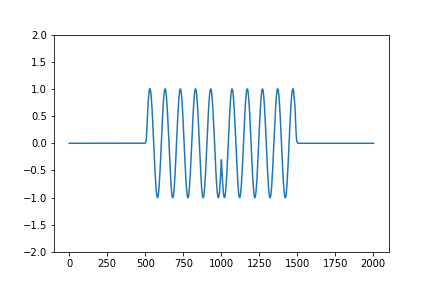

<IPython.core.display.Javascript object>


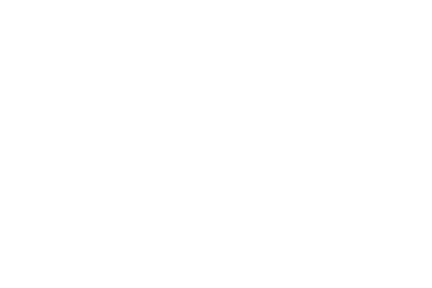

In [9]:
ey = np.zeros(N_T+1)
hx = np.zeros(N_T)

k_source = round(N_T/2)
#print(k_source)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.canvas.draw()

for n in range(0,1000):

    for k in range(0,N_T):
        hx[k] = hx[k] + dt/(dz*mu_0)*(ey[k+1]-ey[k])

    for k in range(1,N_T):
        ey[k] = ey[k] + dt/(dz*epsilon_0)*(hx[k] - hx[k-1])

    #Apply source
    ey[k_source] = ey[k_source] + np.sin(w*n*dt)
    
    if n%10==0:
        ax.clear()
        ax.plot(ey)
        ax.axes.set_ylim(-2,2)
        fig.canvas.draw()
        time.sleep(0.005)
    
#plt.show()
#print(ey)
#plt.plot(ey)